# Clinical Disease  Analysis

## Objective
The primary goal is to extract and present data regarding harmful mutations from the provided ClinVar file. The analysis highlights:
Gene name, Mutation ID number, Mutation Position (chromosome & position), Mutation value (reference & alternate bases), Clinical significance (CLNSIG), Disease implicated

### Initial Observations of file
**Consistency of Field Placement**
The fields like `CHROM`, `POS`, `ID`, `REF`, and `ALT` are consistently placed as they are part of the fixed columns of a VCF file. However, the other required details (`GENEINFO`, `CLNSIG`, `CLNDN`) are within the `INFO` field, which is also consistently placed but contains semi-colon-separated key-value pairs where the order can vary. This complexity underscores the need for robust extraction methods. I noticed the file has different delimiters in the `INFO` section. The two delimiters I noticed are “_” and “|.” 

**Strategy for Data Extraction**
1. **Read the File:** Iterate through each line, skipping headers (lines starting with #).
2. **Splitting Data:** Use the tab delimiter to split each line into its respective fields.
3. **Parsing the INFO Field:** Use a function for Parsing INFO: The `parse_info` function will  convert the `INFO` field into a dictionary, handling missing entries which are those without an equal sign by assigning them a default value of '`Not_Given`' This ensures that no data is inadvertently lost during parsing. Flexible Parsing is incorporated into the script, which can now more reliably handle different entries, including those with varying formats in the `GENEINFO` or other key fields. This ensures that data like gene names are correctly extracted, even if they include extra identifiers or delimiters.
4. **Error Handling:** If certain expected keys are missing in the INFO dictionary, substitute them with '`Not_Given`'.
Extract and Compile Data: For each line, extract all necessary fields, handle missing data, and compile.

In [1]:
# Load the data
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Define a function to parse the INFO field into a dictionary
def parse_info(info_string):
    info_dict = {}
    for part in info_string.split(';'):
        if '=' in part:
            key, value = part.split('=', 2)
            info_dict[key] = value
        else:
            info_dict[part] = 'Not_Given'
    return info_dict

# Placeholder for the extracted data
data = []

# Read the file line by line
with open('clinvar_final.txt', 'r') as file:
    for line in file:
        if not line.startswith('#'):
            parts = line.strip().split('\t')
            if len(parts) < 8:
                continue  # Skip incomplete lines

            chrom, pos, mutation_id, ref, alt, info_string = parts[0], parts[1], parts[2], parts[3], parts[4], parts[7]
            
            # Parsing the INFO field using function
            info = parse_info(info_string)
            
            # Extracting necessary fields
            gene_name = info.get('GENEINFO', 'Not_Given').split(':')[1] if 'GENEINFO' in info else 'Not_Given'
            clnsig = info.get('CLNSIG', 'Not_Given')
            disease = info.get('CLNDN', 'Not_Given').replace('_', ' ').replace('|', ', ')
            mutation_value = f"{ref}->{alt}"
            mutation_position = f"{chrom}:{pos}"
            
            # Append the data
            data.append([
                gene_name,
                mutation_id,
                mutation_position,
                mutation_value,
                clnsig,
                disease
            ])

# Create DataFrame
df = pd.DataFrame(data, columns=[
    'Gene Name',
    'Mutation ID Number',
    'Mutation Position',
    'Mutation Value',
    'Clinical Significance',
    'Disease Implicated'
])
# Remove the first row containing headers
df = df.iloc[1:]

preview of dataset

In [2]:
df.head()

,Gene Name,Mutation ID Number,Mutation Position,Mutation Value,Clinical Significance,Disease Implicated
1,9636,475283,1:1014O42,G->A,Benign,Immunodeficiency 38 with basal ganglia calcifi...
2,9636,542074,1:1O14122,C->T,Uncertain_significance,Immunodeficiency 38 with basal ganglia calcifi...
3,9636,183381,1:1014143,C->T,Pathogenic,Immunodeficiency 38 with basal ganglia calcifi...
4,9636,542075,1:1014179,C->T,Uncertain_significance,Immunodeficiency 38 with basal ganglia calcifi...
5,9636,475278,1:1014217,C->T,Benign,Immunodeficiency 38 with basal ganglia calcifi...


checking for mutations counts within `clinical significance` column

In [3]:
df['Clinical Significance'].value_counts(normalize=False, dropna=False)

Clinical Significance
Uncertain_significance                                                                      47980
Likely_benign                                                                               17885
Pathogenic                                                                                  12313
Likely_pathogenic                                                                            6269
Benign                                                                                       6138
Conflicting_interpretations_of_pathogenicity                                                 5404
Benign/Likely_benign                                                                         3338
Not_Given                                                                                    1797
Pathogenic/Likely_pathogenic                                                                  854
risk_factor                                                                                    9

Grouping Columns: 
-  A pathogenic variant is a genetic alteration that has been demonstrated to cause disease.There is strong evidence from multiple sources, including clinical, functional, and population data, that supports the causative role of this variant in a specific disease. Pathogenic variants are considered clinically actionable, meaning they can inform diagnosis, prognosis, and management of the disease.

- Likely Pathogenic: A likely pathogenic variant is a genetic alteration that is very likely to cause disease, but the evidence is not as strong or as conclusive as for a pathogenic variant. There is significant but not definitive evidence suggesting the variant is disease-causing. This might include data from smaller studies, less robust functional assays, or more limited clinical correlation. Likely pathogenic variants are also considered potentially actionable, but with a slightly higher degree of uncertainty. They may still influence clinical decisions, but with a recognition of the potential need for further validation.

In [4]:
from collections import defaultdict

# Define the mapping dictionary
mapping_groups = {
    'Uncertain_significance': [
        'Uncertain_significance',
        'Uncertain_significance,_risk_factor'
    ],
    'Benign/Likely_benign': [
        'Likely_benign',
        'Benign',
        'Benign/Likely_benign',
        'Benign/Likely_benign,_risk_factor',
        'Benign/Likely_benign,_protective',
        'Benign/Likely_benign,_other',
        'Benign/Likely_benign,_association',
        'Benign,_drug_response',
        'Benign,_other'
    ],
    'Pathogenic': [
        'Pathogenic',
        'Pathogenic,_risk_factor',
        'Pathogenic,_other',
        'Pathogenic,_Affects',
        'Pathogenic,_association,_protective',
        'Pathogenic,_protective'
    ],
    'Likely_pathogenic': [
        'Likely_pathogenic',
        'Pathogenic/Likely_pathogenic',
        'Pathogenic/Likely_pathogenic,_other',
        'Pathogenic/Likely_pathogenic,_risk_factor',
        'Likely_pathogenic,_risk_factor',
        'Likely_pathogenic,_other',
        'Likely_pathogenic,_association'
    ],

    'Conflicting_interpretations_of_pathogenicity': ['Conflicting_interpretations_of_pathogenicity',
        'Conflicting_interpretations_of_pathogenicity,_risk_factor',
        'Conflicting_interpretations_of_pathogenicity,_other',
        'Conflicting_interpretations_of_pathogenicity,_Affects,_other',
        'Conflicting_interpretations_of_pathogenicity,_protective',
        'Conflicting_interpretations_of_pathogenicity,_Affects',
        'Conflicting_interpretations_of_pathogenicity,_association',
        'Conflicting_interpretations_of_pathogenicity,_Affects,_association,_drug_response,_other',
        'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor',],
    'Other': [
        'risk_factor',
        'association',
        'drug_response',
        'Affects',
        'other',
        'Affects,_risk_factor'
    ],
    'Not_Given': [
        'Not_Given'
    ]
}

# Reverse the mapping dictionary to create a direct mapping
direct_mapping = defaultdict(lambda: 'Other')
for key, values in mapping_groups.items():
    for value in values:
        direct_mapping[value] = key

# Apply the mapping to the DataFrame
df['Clinical Significance Grouped'] = df['Clinical Significance'].map(direct_mapping)

# Reorder the columns to place 'Clinical Significance Grouped' next to 'Clinical Significance'
column_order = [
    'Gene Name', 'Mutation ID Number', 'Mutation Position', 'Mutation Value', 
    'Clinical Significance', 'Clinical Significance Grouped', 'Disease Implicated'
]
df = df[column_order]

# Count occurrences of each grouped category
grouped_counts = df['Clinical Significance Grouped'].value_counts()

# Display the counts
print(grouped_counts)


Clinical Significance Grouped
Uncertain_significance                          47981
Benign/Likely_benign                            27373
Pathogenic                                      12330
Likely_pathogenic                                7144
Conflicting_interpretations_of_pathogenicity     5432
Not_Given                                        1797
Other                                             264
Name: count, dtype: int64


In [5]:
# Display the first few rows of the DataFrame to verify the column order
print(df.head())

  Gene Name Mutation ID Number Mutation Position Mutation Value   Clinical Significance Clinical Significance Grouped                                 Disease Implicated
1      9636             475283         1:1014O42           G->A                  Benign          Benign/Likely_benign  Immunodeficiency 38 with basal ganglia calcifi...
2      9636             542074         1:1O14122           C->T  Uncertain_significance        Uncertain_significance  Immunodeficiency 38 with basal ganglia calcifi...
3      9636             183381         1:1014143           C->T              Pathogenic                    Pathogenic  Immunodeficiency 38 with basal ganglia calcifi...
4      9636             542075         1:1014179           C->T  Uncertain_significance        Uncertain_significance  Immunodeficiency 38 with basal ganglia calcifi...
5      9636             475278         1:1014217           C->T                  Benign          Benign/Likely_benign  Immunodeficiency 38 with basal gangl

In [6]:
#remove the first lines of the file 
df.to_csv('parsed_clinvar_data.csv', index=False)

checking for harmful mutations

In [7]:
#Filter for harmful mutations
harmful_df = df[df['Clinical Significance'].str.contains('Pathogenic|Likely_pathogenic')]
print("Total harmful mutations found:", len(harmful_df))

Total harmful mutations found: 19474


In [8]:
#Filter for harmful mutations
harmful_df = df[df['Clinical Significance'].str.contains('Pathogenic|Likely_pathogenic')]
print("Total harmful mutations found:", len(harmful_df))

print(harmful_df['Clinical Significance'].value_counts(normalize=False, dropna=False))

Total harmful mutations found: 19474
Clinical Significance
Pathogenic                                   12313
Likely_pathogenic                             6269
Pathogenic/Likely_pathogenic                   854
Pathogenic,_risk_factor                         11
Pathogenic/Likely_pathogenic,_other              8
Pathogenic/Likely_pathogenic,_risk_factor        6
Likely_pathogenic,_risk_factor                   5
Pathogenic,_other                                2
Pathogenic,_Affects                              2
Pathogenic,_association,_protective              1
Likely_pathogenic,_association                   1
Pathogenic,_protective                           1
Likely_pathogenic,_other                         1
Name: count, dtype: int64


In [9]:
#Display and limit to first 100 results
harmful_df.to_csv("harmful_mutations.csv", index=False)
harmful_df.head(50)
#

,Gene Name,Mutation ID Number,Mutation Position,Mutation Value,Clinical Significance,Clinical Significance Grouped,Disease Implicated
3,9636,183381,1:1014143,C->T,Pathogenic,Pathogenic,Immunodeficiency 38 with basal ganglia calcifi...
9,9636,161455,1:1014316,C->CG,Pathogenic,Pathogenic,Immunodeficiency 38 with basal ganglia calcifi...
10,9636,161454,1:1014359,G->T,Pathogenic,Pathogenic,Immunodeficiency 38 with basal ganglia calcifi...
25,375790,243036,1:1022225,G->A,Pathogenic,Pathogenic,Congenital myasthenic syndrome
27,375790,243037,1:1022313,A->T,Pathogenic,Pathogenic,Congenital myasthenic syndrome
47,375790,574478,1:1041354,CGCCCGCCAGGAGAATGTCTTCAAGAAGTTCGACG->C,Pathogenic,Pathogenic,"Myasthenic syndrome, congenital, 8"
50,375790,126556,1:1O41582,C->T,Pathogenic,Pathogenic,"Congenital myasthenic syndrome, Myasthenic syn..."
64,375790,243038,1:1042136,T->TC,Pathogenic,Pathogenic,Congenital myasthenic syndrome
238,375790,489335,1:1049672,C->T,Likely_pathogenic,Likely_pathogenic,Not Given
271,375790,243039,1:1050473,G->A,Pathogenic,Pathogenic,Congenital myasthenic syndrome


### Most common pathogenic mutations values/Gene names

In [10]:
pathogenic_df = df[df['Clinical Significance Grouped'] =='Pathogenic']

# Filter out rows where the disease is 'Not Given'
pathogenic_df = pathogenic_df[pathogenic_df['Disease Implicated'] != 'Not Given']

# Group by mutation identifiers and count their occurrences 'Mutation ID Number',
pathogenic_counts = pathogenic_df.groupby(['Gene Name',   'Mutation Value']) \
                                 .size() \
                                 .reset_index(name='Count') \
                                 .sort_values(by='Count', ascending=False)

# Display the most common pathogenic mutations
print(pathogenic_counts.head(15))



     Gene Name Mutation Value  Count
319       1281           G->A    186
322       1281           G->T     85
2538      4436           C->T     61
320       1281           G->C     46
4141       659           G->A     43
2333      4292           G->A     40
2296      4292           C->T     38
1671      2956           C->T     36
2575      4436           G->T     35
2348      4292           G->T     35
2176      4000           G->A     32
4126       659           C->T     30
1244    259266           G->A     29
4963      8291           C->T     27
4562      7399           G->A     27


Most common mutation values

In [11]:
# Use value_counts to get the counts of each unique mutation
pathogenic_value_counts = pathogenic_df['Mutation Value'].value_counts()
pathogenic_value_counts.head(15)

Mutation Value
G->A     1797
C->T     1504
G->T      573
T->C      475
A->G      470
C->A      458
G->C      383
C->G      351
T->G      227
T->A      223
A->T      221
A->C      216
CT->C     133
TG->T     127
TC->T     115
Name: count, dtype: int64

Looking for most implicated diseases for the top 15 Mutation values

In [12]:
# Group by Mutation Value and Disease Implicated, and count occurrences
mutation_disease_counts = pathogenic_df.groupby(['Mutation Value', 'Disease Implicated']).size().reset_index(name='Count')

# Filter for the most common mutation values
most_common_mutations = ['G->A', 'C->T', 'G->T', 'C->A', 'A->G', 'T->C', 'G->C', 'C->G', 'T->A', 'A->T', 'T->G', 'A->C', 'CT->C', 'TG->T', 'TC->T']
filtered_counts = mutation_disease_counts[mutation_disease_counts['Mutation Value'].isin(most_common_mutations)]

# Display the filtered results
print(filtered_counts.sort_values(by='Count', ascending=False))

filtered_counts.to_csv("top_mutation_values_diseases.csv")

     Mutation Value                                 Disease Implicated  Count
3812           G->A                     Ehlers-Danlos syndrome, type 4    173
5013           G->T                     Ehlers-Danlos syndrome, type 4     84
4568           G->C                     Ehlers-Danlos syndrome, type 4     45
4287           G->A                     Primary pulmonary hypertension     38
5108           G->T                                     Lynch syndrome     38
...             ...                                                ...    ...
2468           C->T  Hereditary cancer-predisposing syndrome, Hered...      1
2470           C->T  Hereditary cancer-predisposing syndrome, Lynch...      1
2471           C->T  Hereditary cancer-predisposing syndrome, Lynch...      1
2472           C->T  Hereditary cancer-predisposing syndrome, Lynch...      1
6890          TG->T   heterogeneous nuclear ribonucleoprotein G, human      1

[4434 rows x 3 columns]


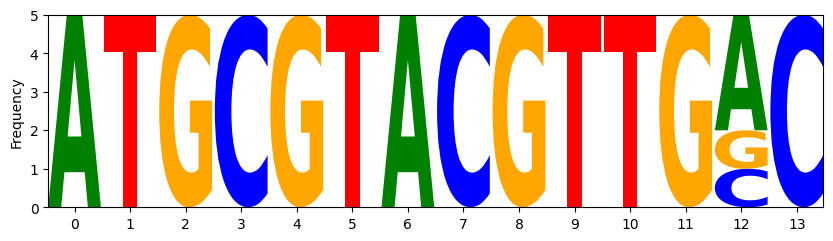

In [14]:


import matplotlib.pyplot as plt
# Then, create the sequence logo
import logomaker
import pandas as pd

# Sample DNA sequence data
sequences = ['ATGCGTACGTTGAC',
             'ATGCGTACGTTGAC',
             'ATGCGTACGTTGAC',
             'ATGCGTACGTTGGC',
             'ATGCGTACGTTGCC']

# Convert sequences to a DataFrame
df = logomaker.alignment_to_matrix(sequences)

# Create a Logo object
logo = logomaker.Logo(df)

# Display the logo
logo.style_xticks(anchor=0, spacing=1)
logo.ax.set_ylabel('Frequency')
plt.show()
